To make full use of this notebook, then go to: File > Save a copy in Drive...

This will allow you to keep a version in your own Drive that you can work from, and is recommended. You can then close out the original tab and work on the copied version.

To find where it's been copied to go: File > Locate in Drive

# Building LSTMs

Welcome to building LSTMs for sequence prediction. 
Lots of sequence prediction tasks exist, where we can model data that relies on previous time points. 
Here we'll look at the case of pairs trading: https://medium.com/auquan/pairs-trading-data-science-7dbedafcfe5a

Stages:
1.   Setting up the workbook for MAXIMUM SPEED
2.   Loading the required modules for the workbook to work
3.   Setting up an AlphaVantage API for stock / forex data & loading the data
4.   Pre-processing the data 
5.   Defining, training and testing a pairs predicition model
6.   Let's guess only direction
7.   Back to the drawing board
8.   Simple strategy

### 1. MAXIMUM SPEED

Google Colab generously gives you one GPU (graphics processing unit) to run computations on.
A GPU is much quicker than a CPU, in that it can perform many more FLOPs (floating point operations [read "calculations"]) per second.

To turn this feature on go to:
Edit > Notebook Settings > Change the hardware accelerator to GPU


In [1]:
# If this code runs and says "Found GPU ..." etc then congrats, you've turned the computation machine to full volume

import tensorflow as tf # Importing our first module (as below) but we need it 
                        # earlier to check whether we have the GPU running in the correct place!
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


### 2. Loading the required modules

Python relies on loading in other modules and libraries that have special in-built functions for tasks that we want to perform. 

Keras (which is a higher-level abstraction of tensorflow) is a super easy API which has pre-programmed a lot of the dependancies and code necessary to completely build and train a neural net.

Next to each module I've included a comment about wtf it does.

In [2]:
import numpy as np   # Loading in numpy (a module for vector / array calculations) anc calling it "np"
import tensorflow as tf # In case we didn't bother running the above piece of code

from keras.models import Sequential, load_model # Keras holds all the tools, here we're accessing its "models" library 
                                                # and installing the "Sequential" model that allows us to stack all the layers 
                                                # in the CNN and it takes care of all the maths and setup. load_model allows us to
                                                # load previously saved models.


from keras.layers import Dense, Dropout, Activation, LSTM 
# Dense: the old fully-connected layer
# Dropout: randomly drops out some of the connections during each training phase (may be helpful in comp...)
# Activation: your choice of activation function to apply for non-linearities
# LSTM: the memory, sequence prediction layer - it's all built in to LSTM!

from keras.callbacks import ModelCheckpoint # Allows us to store versions of the model as it goes through its training, 
                                            # may be useful in competition time...

import pandas as pd   # pandas allows us to deal with Series data and DataFrames
import matplotlib.pyplot as plt # this gives us the ability to plot graphs etc.
from sklearn.utils import shuffle # this will allow us to shuffle our data
from sklearn.preprocessing import MinMaxScaler # as LSTMs like stationary data in a nice range, then this may help in pre-processing


!pip install alpha_vantage # alpha_vantage is a non-open-source package, so we have to ask Google to install it on this notebook!

Using TensorFlow backend.


  Created wheel for alpha-vantage: filename=alpha_vantage-2.1.3-cp36-none-any.whl size=14870 sha256=afaf7a8c9886afcd3130590ded8d631dc9bd17aeb575448084bde242e0df45a4
  Stored in directory: /root/.cache/pip/wheels/d4/75/c2/483b0a988fd965b1128c1396a0ffadfb8903bd2bb569220048
Successfully built alpha-vantage


### 3. Getting your own AlphaVantage API & loading the data

Unfortunately, the majority of code available on Google still relies on being able to grab the data from Yahoo Finance or Google Finance. 
Google and Yahoo have depreciated their APIs, so they don't work.

I've done some searching, and AlphaVantage appears a good substitute. We've installed it above, but now we need to be able to call it with a personal key.

Go to: https://www.alphavantage.co/support/#api-key
In this case, select: Student, Oxford, enter your email.

In the text below the boxes you should then get an API key that is personal to you, it should look something like: IUV7PTZFRUHGG0KH ie. a load of numbers and letters. Copy that over "YOUR_API_KEY" key below:

(And run the code block)

In [0]:
api_key = 'HCLMKP3C5B2AQNIM' # so you should have something like: api_key = 'IUV7PTZFRUHGG0KH' <- the quote marks are important

We load a couple of TimeSeries from medical companies for all the data they have.

For all of what we do, you can find good documentation here: https://www.alphavantage.co/documentation/

In [0]:
from alpha_vantage.timeseries import TimeSeries
ts = TimeSeries(key=api_key, ) # This is my API key included in a function that allows us to call stock data 

mdt, mdt_meta = ts.get_daily_adjusted(symbol = 'MDT', outputsize = 'full') # gets all the data for Medtronic PLC
mrk, mrk_meta = ts.get_daily_adjusted(symbol = 'MRK', outputsize = 'full') # gets all the data for Merck & Co. Inc.

Let's get an idea of what we're looking at:

In [6]:
print(mdt_meta) # Tells us all about what data we've just downloaded
print(mrk_meta) # Their recent refresh rates show us that they're still in existence

{'1. Information': 'Daily Time Series with Splits and Dividend Events', '2. Symbol': 'MDT', '3. Last Refreshed': '2020-02-07', '4. Output Size': 'Full size', '5. Time Zone': 'US/Eastern'}
{'1. Information': 'Daily Time Series with Splits and Dividend Events', '2. Symbol': 'MRK', '3. Last Refreshed': '2020-02-07', '4. Output Size': 'Full size', '5. Time Zone': 'US/Eastern'}


In [7]:
mdt['2020-01-24']  # shows us just the data from 24th Jan 2020, we have a lot of these...

{'1. open': '120.8900',
 '2. high': '121.0300',
 '3. low': '118.8650',
 '4. close': '119.2600',
 '5. adjusted close': '119.2600',
 '6. volume': '3382523',
 '7. dividend amount': '0.0000',
 '8. split coefficient': '1.0000'}

In [8]:
print(len(mdt)) # want to find out if the data have different lengths
print(len(mrk))

5033
5033


Let's do a little bit of pre-processing now, just to extract the adjusted close price as a time series and do some visualisation.

More pre-processing will be involved for the LSTM shape, which is why I'm doing this bit here...

In [0]:
import time

dates = list(set(mdt.keys()) & set(mrk.keys())) # find the intersection of all the dates
dates_as_seconds = [time.mktime(time.strptime(date, "%Y-%m-%d")) for date in dates] # convert all the dates to seconds since 1st Jan 1970, this technique uses list comprehension
dates_as_seconds.sort() # sort into ascending order
ordered_dates = [time.strftime("%Y-%m-%d", time.localtime(sec)) for sec in dates_as_seconds]

mrk_close = pd.Series(index=dates_as_seconds) # Creates an empty TimeSeries, with the ordered seconds as an index
mdt_close = pd.Series(index=dates_as_seconds)
ratio = pd.Series(index=dates_as_seconds)

for key in ordered_dates: # seach over the intersection of dates of inx and cop

  seconds = time.mktime(time.strptime(key, "%Y-%m-%d"))

  mdt_price = mdt[key]['5. adjusted close'] # extracts the string of the adjusted close, ie. '119.2600', for each date
  mdt_price = float(mdt_price) # converts the string to a number: '119.2600' to 119.2600
  mdt_close[seconds] = mdt_price # adds the price to our TimeSeries
  
  # repeat for inx:
  mrk_price = mrk[key]['5. adjusted close']
  mrk_price = float(mrk_price) 
  mrk_close[seconds] = mrk_price # adds the price to our TimeSeries

  # create ratio:
  ratio[seconds] = mdt_price/mrk_price

In [10]:
ratio # looks like it worked!

9.498816e+08    1.014870
9.499680e+08    1.020123
9.500544e+08    1.061856
9.501408e+08    1.078707
9.502272e+08    1.093168
                  ...   
1.580688e+09    1.350927
1.580774e+09    1.357967
1.580861e+09    1.405336
1.580947e+09    1.415733
1.581034e+09    1.398096
Length: 5033, dtype: float64

### 4. Pre-processing the data 

Now it's all loaded, what does it look like? 

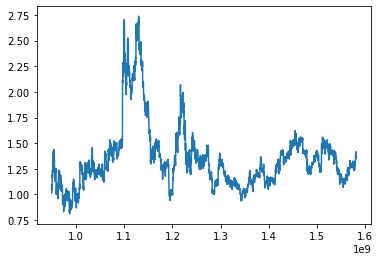

In [11]:
plt.plot(ratio)
plt.show()

We're going to get an LSTM to predict the result of the next time step using the previous 50 pieces of data (in this case the previous 50 days of the ratio).

Therefore, what we want to train our model is examples of data that look like:
[day x, day x+1, ..., day x+50] and [day x+51] 

So that we can feed in the 50 days of data and get it to predict the 51st, which we can then compare to the true result: [day x+51].

Going to define a function to build an array of the type:

[day x, ..., day x+51]

In [0]:
def gen_frame(timeseries, window_size):
  time2 = timeseries.copy() # creates a copy of our time series, as we'll be messing with it in a moment.

  for i in range(window_size):
    time2 = pd.concat([time2, timeseries.shift(-(i+1))], axis = 1) # iteratively builds a dataframe with rows that look like: [day x, day x+1, ..., day x+50, day x+51]

  time2.dropna(axis = 0, inplace = True)  # There are rows with zeros, as the first 50 pieces of data don't have 50 prices before them that we are able to predict on. This gets rid of those so we only have complete data
  print(time2.shape)
  return time2 # return the big array we just generated

In [13]:
window_size = 50

ratio2 = gen_frame(ratio, window_size)

(4983, 51)


In [14]:
ratio2 # to check it looks legit

,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9.498816e+08,1.014870,1.020123,1.061856,1.078707,1.093168,1.088686,1.073610,1.047565,1.141466,1.192739,1.164515,1.191286,1.238007,1.222168,1.209076,1.220160,1.263605,1.276216,1.378930,1.351988,1.416154,1.329400,1.262211,1.327870,1.358811,1.280429,1.264266,1.249503,1.295777,1.336605,1.285181,1.311125,1.375807,1.374492,1.438922,1.399039,1.336778,1.228570,1.277659,1.274539,1.273936,1.264388,1.317683,1.321718,1.342119,1.279064,1.286747,1.199806,1.179837,1.156295,1.219342
9.499680e+08,1.020123,1.061856,1.078707,1.093168,1.088686,1.073610,1.047565,1.141466,1.192739,1.164515,1.191286,1.238007,1.222168,1.209076,1.220160,1.263605,1.276216,1.378930,1.351988,1.416154,1.329400,1.262211,1.327870,1.358811,1.280429,1.264266,1.249503,1.295777,1.336605,1.285181,1.311125,1.375807,1.374492,1.438922,1.399039,1.336778,1.228570,1.277659,1.274539,1.273936,1.264388,1.317683,1.321718,1.342119,1.279064,1.286747,1.199806,1.179837,1.156295,1.219342,1.174996
9.500544e+08,1.061856,1.078707,1.093168,1.088686,1.073610,1.047565,1.141466,1.192739,1.164515,1.191286,1.238007,1.222168,1.209076,1.220160,1.263605,1.276216,1.378930,1.351988,1.416154,1.329400,1.262211,1.327870,1.358811,1.280429,1.264266,1.249503,1.295777,1.336605,1.285181,1.311125,1.375807,1.374492,1.438922,1.399039,1.336778,1.228570,1.277659,1.274539,1.273936,1.264388,1.317683,1.321718,1.342119,1.279064,1.286747,1.199806,1.179837,1.156295,1.219342,1.174996,1.161037
9.501408e+08,1.078707,1.093168,1.088686,1.073610,1.047565,1.141466,1.192739,1.164515,1.191286,1.238007,1.222168,1.209076,1.220160,1.263605,1.276216,1.378930,1.351988,1.416154,1.329400,1.262211,1.327870,1.358811,1.280429,1.264266,1.249503,1.295777,1.336605,1.285181,1.311125,1.375807,1.374492,1.438922,1.399039,1.336778,1.228570,1.277659,1.274539,1.273936,1.264388,1.317683,1.321718,1.342119,1.279064,1.286747,1.199806,1.179837,1.156295,1.219342,1.174996,1.161037,1.156601
9.502272e+08,1.093168,1.088686,1.073610,1.047565,1.141466,1.192739,1.164515,1.191286,1.238007,1.222168,1.209076,1.220160,1.263605,1.276216,1.378930,1.351988,1.416154,1.329400,1.262211,1.327870,1.358811,1.280429,1.264266,1.249503,1.295777,1.336605,1.285181,1.311125,1.375807,1.374492,1.438922,1.399039,1.336778,1.228570,1.277659,1.274539,1.273936,1.264388,1.317683,1.321718,1.342119,1.279064,1.286747,1.199806,1.179837,1.156295,1.219342,1.174996,1.161037,1.156601,1.128925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.574122e+09,1.314776,1.313676,1.295514,1.299536,1.306968,1.277265,1.286367,1.280299,1.276832,1.272782,1.265000,1.266796,1.275406,1.255139,1.248773,1.258115,1.257211,1.266713,1.276663,1.278410,1.263745,1.255119,1.236045,1.235517,1.238264,1.232538,1.238798,1.240580,1.247389,1.244676,1.248000,1.253710,1.283520,1.314898,1.324569,1.325142,1.318400,1.301457,1.281735,1.303575,1.308453,1.337335,1.350697,1.365967,1.387067,1.384785,1.381797,1.356832,1.365896,1.351124,1.350927
1.574208e+09,1.313676,1.295514,1.299536,1.306968,1.277265,1.286367,1.280299,1.276832,1.272782,1.265000,1.266796,1.275406,1.255139,1.248773,1.258115,1.257211,1.266713,1.276663,1.278410,1.263745,1.255119,1.236045,1.235517,1.238264,1.232538,1.238798,1.240580,1.247389,1.244676,1.248000,1.253710,1.283520,1.314898,1.324569,1.325142,1.318400,1.301457,1.281735,1.303575,1.308453,1.337335,1.350697,1.365967,1.387067,1.384785,1.381797,1.356832,1.365896,1.351124,1.350927,1.357967
1.574294e+09,1.295514,1.299536,1.306968,1.277265,1.286367,1.280299,1.276832,1.272782,1.265000,1.266796,1.275406,1.255139,1.248773,1.258115,1.257211,1.266713,1.276663,1.278410,1.263745,1.255119,1.236045,1.235517,1.238264,1.232538,1.238798,1.240580,1.247389,1.244676,1.248000,1.253710,1.283520,1.314898,1.324569,1.325142,1.318400,1.301457,1.281735,1.303575,1.308453,1.337335,1.350697,1.3

Time to create training and test sets.
We're going to use the first 80% of the data as a training set and the most recent 20% as our test set.

I've defined some useful functions here to manipulate the arrays into the format we want:

In [0]:
# We will need to cut off the labels from the data, I've made it a function, so it's quicker:
def cut_labels(dataset):
  prices = dataset.iloc[:,:-1] # get the last item in each row and store in a frame <- [day x+51]
  labels = dataset.iloc[:,-1] # get all but the last item in the row (ie. the other 50 days) <- [day x, ..., day x+50]
  return labels, prices # returns the labels and prices to us as two separate frames.

# We will also want to split our original array on the pre-defined row, before cutting all the labels, and converting into our test and train sets:
def gen_splits(dataset, nrow):
  train = dataset.iloc[:nrow, :] # cuts our dataset at the nrow row
  test = dataset.iloc[nrow:,:] # rest of the dataset
  train_y, train_x = cut_labels(train) # uses our previous function to get the labels
  test_y, test_x = cut_labels(test)

  train_x = train_x.values # extract just the values of the series (converts to array, allowing us to use .reshape())
  test_x = test_x.values

  train_x = train_x.reshape(train_x.shape[0], train_x.shape[1], 1) # we have to respahe the array from (x, y) to (x, y, 1) to tell the LSTM to look over just one channel.
  test_x = test_x.reshape(test_x.shape[0], test_x.shape[1], 1) # explanation of this in the code block below

  return train_x, train_y, test_x, test_y # returns all the arrays we've created in the function


We have had to reshape the data to tell our LSTM that we're only looking over 1 channel ie. we're only using the price to predict the movement. 

If we had both price and momentum data for each day, we could use both to predict the next price (eg. we're using two channels for the prediction).

Time to actually use the functions to cut the frames:

In [0]:
nrow = round(0.8*ratio2.shape[0]) # sets the cut point at ~80% of the data
rat_x, rat_y, rat_tx, rat_ty = gen_splits(ratio2, nrow)

### 5. Defining, training and testing a FX predicition model

Now we've cut the data into the formats we want we can build our LSTM model using Keras (an API that allows us to build the models as if they were lego)!

Define:

In [17]:
# This is an example of a stacked LSTM, which takes the sequence coming from the previous LSTM as its input sequence

model = Sequential() # this allows us to start building the models layer by layer
model.add(LSTM(input_shape = (50,1), output_dim= 50, return_sequences = True)) # LSTM layer, that will return 50 sequences of length 50
model.add(LSTM(100, return_sequences=True)) # Takes the 50 sequences of length 50, and will return 100 of length 50
model.add(LSTM(100)) # takes the 100 sequences of length 50, and just produces 100 1-value predictions.
model.add(Dense(1)) # the thinking layer, that translates the output of the previous LSTM cells (100 1-value predictions) to a single prediction.
model.add(Activation("linear")) # scales the prediction linearly
model.compile(loss="mse", optimizer="adam") # we're minimising over the Mean-Squared error and using the Adam optimiser

print(model.summary())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(50, 1), return_sequences=True, units=50)`
  This is separate from the ipykernel package so we can avoid doing imports until



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 50)            10400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 100)           60400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 151,301
Trainable params: 151,301
Non-trainable params: 0
_________________________________________________________________
None


Train:

We're going to train each model for 5 epochs, with a batch size of 20 sequences per model update

In [18]:
model.fit(rat_x, rat_y, batch_size=20, epochs=5, verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/5





3986/3986 [==============================] - 51s 13ms/step - loss: 0.0595
Epoch 2/5
3986/3986 [==============================] - 42s 10ms/step - loss: 0.0052
Epoch 3/5
3986/3986 [==============================] - 42s 11ms/step - loss: 0.0047
Epoch 4/5
3986/3986 [==============================] - 42s 11ms/step - loss: 0.0043
Epoch 5/5
3986/3986 [==============================] - 42s 11ms/step - loss: 0.0029


Now let's test.

We're going to get the models to predict and store the predictions in a dataframe.

We're then going to convert all the predictions to price guesses (instead of returns), and see how close the models were to the true data.

We're then going to see how accurate each model was in guessing the direction of the market.

In [0]:
predictions = pd.DataFrame(index=rat_ty.keys(), data=rat_ty.values, columns=['True Ratio']) # creates a dataframe for us to store our guesses in

model_predictions = model.predict(rat_tx) # get model to predict on our test data

predictions['Predicted Ratio'] = model_predictions

Quick check on what it's all looking like:

In [20]:
predictions.head(10) # gets us the first 10 rows of our predictions dataframe

,True Ratio,Predicted Ratio
1.449706e+09,1.563063,1.538733
1.449792e+09,1.574515,1.543603
1.450051e+09,1.578152,1.548856
1.450138e+09,1.593727,1.554385
1.450224e+09,1.482164,1.560974
1.450310e+09,1.475528,1.557615
1.450397e+09,1.486893,1.542981
1.450656e+09,1.501162,1.521972
1.450742e+09,1.493051,1.501382
1.450829e+09,1.487223,1.484838


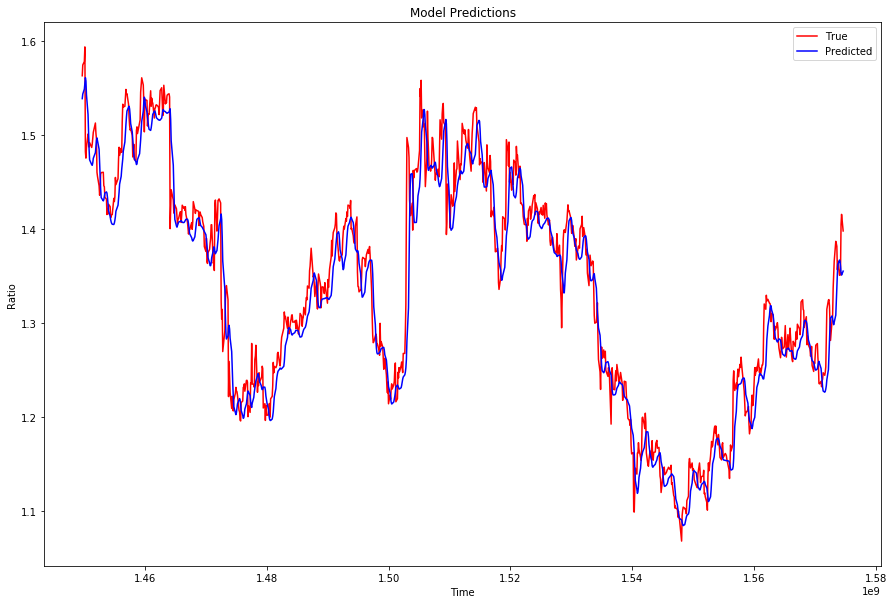

In [21]:
plt.figure(figsize=(15,10)) # set the size of the graph we want to look at
plt.plot(predictions['True Ratio'], 'r', label = 'True') # plot the true ratio in red and give it the label 'True'
plt.plot(predictions['Predicted Ratio'], 'b', label = 'Predicted') # plot thr predicted ratio in blue and give it the label 'Predicted'
plt.legend() # add the legend to the graph
plt.title('Model Predictions') # give it a title
plt.xlabel('Time') # x-axis label is time
plt.ylabel('Ratio') # y-axis label is ratio
plt.show() # show the graph

Let's find out how accurate the model was in terms of predicting the direction of the market:

In [0]:
direction_market = np.zeros(len(predictions.index)) # create array of zero with same length as our predictions
direction_model = direction_market.copy() # same again
difference = direction_market.copy() # same again

for i in range(1, len(predictions.index)): # from the second prediction onwards:
  now = predictions.index[i] # get the date of the day
  yesterday = predictions.index[i-1] # get the date of the day before

  market_now = predictions.loc[now, 'True Ratio'] # get the price of the market today
  market_then = predictions.loc[yesterday, 'True Ratio'] # get the price of the market the day before

  model_now = predictions.loc[now, 'Predicted Ratio'] # get the price prediction of today

  if model_now > market_then: # if the model thinks it'll go up, it gives a 1, else it stays a zero
    direction_model[i] = 1

  if market_now > market_then: # gives an up movement in the market a 1, a down movement a 0
    direction_market[i] = 1

  difference[i] = abs(direction_market[i] - direction_model[i]) # an array of where the model was wrong

Want to find out how often the market moves up:

In [23]:
100*np.mean(direction_market)

49.64894684052156

So the market moves up 49.8% of the time, therefore if we always predict it'll fall we'll have 50.2% accuracy without even having to specify a model!

What was the accuracy of our model:

In [24]:
accuracy = 100*(1-np.mean(difference)); accuracy # calculates the average of how many times the model got it right.

50.95285857572718

52% accuracy (for me) in prediciting the direction of the ratio, so we're on the same level as blind guessing...
Individual results may differ due to different data (loaded on a different day) and different initialisation upon compiling the model.

### 6. Let's just guess direction and see how good we get:

- Redo the labels of our data
- Define and Train a new model
- Test model and get accuracy

Redo our model labels:

In [0]:
labels, prices = cut_labels(ratio2) # re-does our labels and price data

In [0]:
y_set = labels.copy()

for i in range(len(prices)):
  day_before = prices.iloc[i, -1] # get last price
  now = labels.iloc[i] # get price the day after

  if now >= day_before:
    y_set.iloc[i] = 1 # if the stock goes up, give it a label 1.

  else:
    y_set.iloc[i] = 0 # stock goes down, it gets label 0.

In [0]:
nrow = round(0.8*ratio2.shape[0]) # sets the cut point at ~80% of the data

train_x = prices.iloc[:nrow, :] # cuts our prices set at the nrow row
test_x = prices.iloc[nrow:,:] # rest of the prices set
train_x = train_x.values # extract just the values of the series (converts to array, allowing us to use .reshape())
test_x = test_x.values
train_x = train_x.reshape(train_x.shape[0], train_x.shape[1], 1) # we have to respahe the array from (x, y) to (x, y, 1) to tell the LSTM to look over just one channel.
test_x = test_x.reshape(test_x.shape[0], test_x.shape[1], 1) # explanation of this in the code block below

train_y = y_set.iloc[:nrow] # gets our up/down train labels
test_y = y_set.iloc[nrow:] # gets our up/down test labels

Define and train model:

In [28]:
# This is an example of a stacked LSTM, which takes the sequence coming from the previous LSTM as its input sequence

model2 = Sequential() # this allows us to start building the models layer by layer
model2.add(LSTM(input_shape = (50,1), output_dim= 50, return_sequences = True)) # LSTM layer, that will return 50 sequences of length 50
model2.add(LSTM(100, return_sequences=True)) # Takes the 50 sequences of length 50, and will return 100 of length 50
model2.add(LSTM(100)) # takes the 100 sequences of length 50, and just produces 100 1-value predictions.
model2.add(Dense(100, activation='relu')) # a thinking layer of 100 nodes.
model2.add(Dense(50, activation='relu')) # a thinking layer of 50 nodes.
model2.add(Dense(1, activation='sigmoid')) # the thinking layer, that translates the output of the previous LSTM cells (100 1-value predictions) to a single prediction in [-1,1]
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) # we're minimising over the Mean-Squared error and using the Adam optimiser

print(model2.summary())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(50, 1), return_sequences=True, units=50)`
  This is separate from the ipykernel package so we can avoid doing imports until



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 50, 50)            10400     
_________________________________________________________________
lstm_5 (LSTM)                (None, 50, 100)           60400     
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 166,401
Trainable params: 166,401
Non-trainable params: 0
_______________________________________________

In [29]:
model2.fit(train_x, train_y, batch_size=20, epochs=3, verbose=1) # fit the model for three epochs on a batch size of 20.

Epoch 1/3
3986/3986 [==============================] - 44s 11ms/step - loss: 0.6941 - acc: 0.4905
Epoch 2/3
3986/3986 [==============================] - 42s 11ms/step - loss: 0.6934 - acc: 0.4862
Epoch 3/3
3986/3986 [==============================] - 42s 11ms/step - loss: 0.6933 - acc: 0.4960


Test Model:

In [30]:
loss, accuracy = model2.evaluate(test_x, test_y, verbose=1) # evaluates the model on our test set
print(accuracy) # reports the accuracy

997/997 [==============================] - 3s 3ms/step
0.5025075225975951


Pretty much at break even! 

Really really close to random guessing. Not good.

### 7. Back to the drawing board with the data

Is there a way of normalising it so that we have a more stationary distribution?

Here we normalise the ratio using a rolling window of comparing its 5 to its 60 day average:

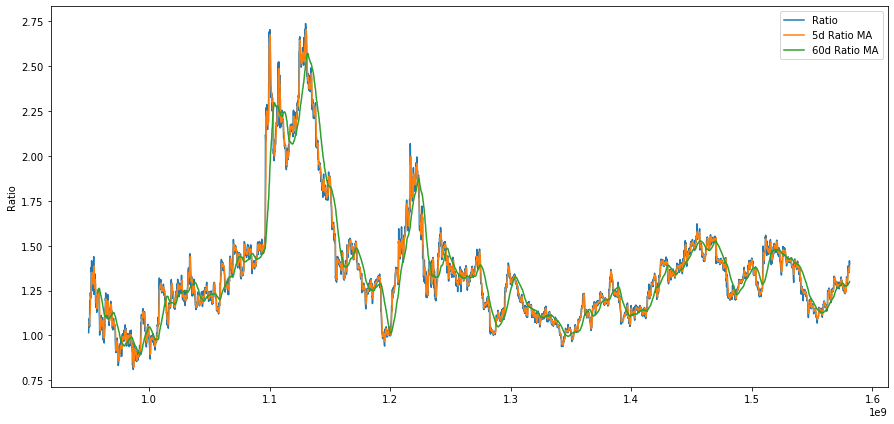

In [31]:
ratios_mavg5 = ratio.rolling(window=5, center=False).mean() # calculates the 5 day rolling average
                               
ratios_mavg60 = ratio.rolling(window=60,center=False).mean() # calculates the 60 day rolling average
std_60 = ratio.rolling(window=60,center=False).std() # calculates the 60 day standard deviation
zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60 # gives a series based on these numbers

plt.figure(figsize=(15,7)) # size the plot
plt.plot(ratio.index, ratio.values) # plot the ratio
plt.plot(ratios_mavg5.index, ratios_mavg5.values) # plot its 5-day avg
plt.plot(ratios_mavg60.index, ratios_mavg60.values) # plot its 60-day avg

plt.legend(['Ratio','5d Ratio MA', '60d Ratio MA']) # give it a legend
plt.ylabel('Ratio') # and a y-label
plt.show() # show the plot

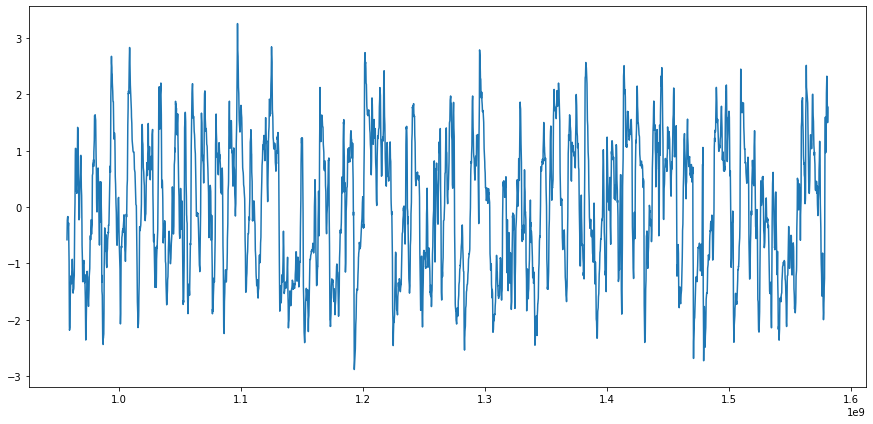

In [32]:
# plot the zscore based on the moving averages
plt.figure(figsize=(15,7))
plt.plot(zscore_60_5)
plt.show()

In [33]:
window_size = 50
ratio3 = gen_frame(zscore_60_5, window_size) # generate a new dataframe based on the zscore moving data

(4924, 51)


In [0]:
nrow = round(0.8*ratio3.shape[0]) # sets the cut point at ~80% of the data
norm_x, norm_y, norm_tx, norm_ty = gen_splits(ratio3, nrow) # form the data sets

In [35]:
norm = Sequential() # this allows us to start building the models layer by layer
norm.add(LSTM(input_shape = (50,1), output_dim= 50, return_sequences = True)) # LSTM layer, that will return 50 sequences of length 50
norm.add(LSTM(100, return_sequences=True)) # Takes the 50 sequences of length 50, and will return 100 of length 50
norm.add(LSTM(100)) # takes the 100 sequences of length 50, and just produces 100 1-value predictions.
norm.add(Dense(1)) # the thinking layer, that translates the output of the previous LSTM cells (100 1-value predictions) to a single prediction.
norm.add(Activation("linear")) # scales the prediction linearly
norm.compile(loss="mse", optimizer="adam") # we're minimising over the Mean-Squared error and using the Adam optimiser

print(norm.summary())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(50, 1), return_sequences=True, units=50)`
  


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 50, 50)            10400     
_________________________________________________________________
lstm_8 (LSTM)                (None, 50, 100)           60400     
_________________________________________________________________
lstm_9 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 151,301
Trainable params: 151,301
Non-trainable params: 0
_________________________________________________________________
None


In [36]:
norm.fit(norm_x, norm_y, batch_size=20, epochs=5, verbose=1) # train for 5 epochs with a batch size of 20.

Epoch 1/5
3939/3939 [==============================] - 45s 11ms/step - loss: 0.2447
Epoch 2/5
3939/3939 [==============================] - 42s 11ms/step - loss: 0.0187
Epoch 3/5
3939/3939 [==============================] - 42s 11ms/step - loss: 0.0155
Epoch 4/5
3939/3939 [==============================] - 42s 11ms/step - loss: 0.0128
Epoch 5/5
3939/3939 [==============================] - 42s 11ms/step - loss: 0.0123


In [0]:
predictions = pd.DataFrame(index=norm_ty.keys(), data=norm_ty.values, columns=['True Ratio']) # creates a dataframe for us to store our guesses in

norm_predictions = norm.predict(norm_tx) # get model to predict on our test data

predictions['Predicted Ratio'] = norm_predictions

In [0]:
direction_market = np.zeros(len(predictions.index)) # create array of zero with same length as our predictions
direction_model = direction_market.copy() # same again
difference = direction_market.copy() # same again

for i in range(1, len(predictions.index)): # from the second prediction onwards:
  now = predictions.index[i] # get the date of the day
  yesterday = predictions.index[i-1] # get the date of the day before

  market_now = predictions.loc[now, 'True Ratio'] # get the price of the market today
  market_then = predictions.loc[yesterday, 'True Ratio'] # get the price of the market the day before

  model_now = predictions.loc[now, 'Predicted Ratio'] # get the price prediction of today

  if model_now > market_then: # if the model thinks it'll go up, it gives a 1, else it stays a zero
    direction_model[i] = 1

  if market_now > market_then: # gives an up movement in the market a 1, a down movement a 0
    direction_market[i] = 1

  difference[i] = abs(direction_market[i] - direction_model[i]) # an array of where the model was wrong

In [39]:
accuracy = 100*(1-np.mean(difference)); accuracy # again, calculate the accuracy of the predictions 

75.93908629441624

Now that is seems better (but results are also variant). The reason being is that the data is now more stationary around its mean, allowing a consistent distribution for the LSTM to learn from.

Time to build a strategy...

### 8. Simple Strategy

Here we build a simple pairs strategy that buys the pair (ie. buys MDT and sells and equivalent value of MRK) when the model predicts a rise, and will then sell the pair (sell the holding in MDT and buy back the holding in MRK) next time the model predicts a fall:

In [0]:
mdt_values = pd.Series(data=[mdt_close[key] for key in predictions.index], index = predictions.index) # fetch the price of MDT in our test timeframe
mrk_values = pd.Series(data=[mrk_close[key] for key in predictions.index], index= predictions.index) # fetch the prices of MRK
predictions['Signal'] = direction_model
predictions['MDT'] = mdt_values # add them both to our dataframe for ease of use.
predictions['MRK'] = mrk_values

In [0]:
predictions # looking good

In [0]:
def trade(stat, signal, rat_now, old_rat, top_price, bottom_price):

  if stat == 0: # ie. we have no trades
    if signal == 1: # ie. we get a buy signal.
      mdt = -top_price # we buy 1 share of mdt, costs us money therefore negative
      mrk = +bottom_price*rat_now # we sell a dollar equivalent amount of mrk, gives us money therefore positive
      stat == 1 # we are now in a bought position

      return mdt, mrk, rat_now, stat # return all trade information

    else: # signal == 0 ie. we get a sell signal.
      mdt = +top_price # sell a share of mdt
      mrk = -bottom_price*rat_now # buy and equivalent amount of mrk.
      stat == -1 # we are now in a sold position

      return mdt, mrk, rat_now, stat # return all trade info.

  if stat == 1: #ie. we are in a buy position, and we can only sell:
    if signal == 1: # can't buy again, so ignore
      return 0, 0, old_rat, 1
    else: #signal == 0 and we can sell out of our position:
      mdt = +top_price # sell a share of mdt
      mrk = -bottom_price*old_rat # buy all shares needed of mrk to nullify position
      stat == 0 # return to no trades
      return mdt, mrk, 0, stat
  
  if stat == -1: # ie. we are in a sold position and need to buy back:
    if signal == 0: # can't sell again, so ignore
      return 0, 0, old_rat, -1
    else: # signal == 1
      mdt = -top_price # buying back one share of mdt
      mrk = +bottom_price*old_rat # selling our shares of mrk
      stat == 0 # return to no trades
      return mdt, mrk, 0, stat

    

      

def buy1_sell1(dataframe):

  i = 1 # start from second row of the predictions set, as the second prediction is based on the first true ratio...
  stat1 = 0 # start with no trades
  mdt_data = np.zeros(len(dataframe)) # array to store our mdt trades
  mrk_data = mdt_data.copy() # array to store our mrk trades
  shares = mdt_data.copy() # array to store how many shares long/short we are of mrk
  rat_old = 0 # the mrk shares we originally have is zero

  while i < len(dataframe): # for the entire length of the dataframe:
    stat = stat1 # set our state as the one we previously calculated from out trade func. below
    signal = dataframe.iloc[i,4] # our signal is in the ith row of the 5th column of the predictions set
    rat_now = dataframe.iloc[i-1,0] # the ratio that we were predicting at was the row before in the 1st column
    old_rat = rat_old # keep tally of our mrk shares to feed into the trade func.
    top_price = dataframe.iloc[i-1,2] # the mdt price at time (row of prediction) is the row before in the 3rd column
    bottom_price = dataframe.iloc[i-1,3] # smae again, but for mrk in the 4th column
    mdt_data[i], mrk_data[i], rat_old, stat1 = trade(stat, signal, rat_now, old_rat, top_price, bottom_price) # trade based on the above, and return their new values
    i += 1 # index our counter

  profits = mdt_data + mrk_data # add together how much we're buying / selling of each stock

  return np.sum(profits), np.cumsum(profits) # return just the total profit at the end, and the running total of profits

In [0]:
def no_sell(start, size, spread, predictions):
  
  direction_model = predictions['Signal']
  mdt_values = predictions['MDT'] # mdt is on top of the pair
  mrk_values = predictions['MRK'] # mrk is on the bottom of the pair

  cash = np.zeros(len(predictions)+1)
  cash[0] = start

  mdt_mon = np.zeros(len(predictions)+1)
  mrk_mon = np.zeros(len(predictions)+1)

  mdt_stock = np.zeros(len(predictions)+1)
  mrk_stock = np.zeros(len(predictions)+1)

  for i in range(1,len(predictions)+1):
    if direction_model[i] == 1: #ie. ratio is due to go up.
      dollar = cash[i-1]*0.1

    if direction_model[i] == 0: #ie. ratio is due to go down.

In [0]:
total, rolling = buy1_sell1(predictions) # enact the fucntion above on our predictions frame

Not bad! I've made a total of $57,415 in ~2.7 years (see below)

Again, your results will differ based on the model and when you request the data.

In [0]:
print(len(rolling)) # prints the number of days we were running the trade for
total # prints how much we earnt

Let's see what our profit curve looks like:

In [0]:
cumulative = pd.Series(data=rolling, index=predictions.index)
plt.figure(figsize=(15,7))
plt.plot(cumulative)
plt.show()

**NOTES OF WARNING:**



1.   *We haven't included the cost of trading, there will be a spread that we incur when buying / selling these stocks.*
2.   *We've bought exact fractions of MRK, this may not be possible in the real market.*
3.   *This function gives us no idea how long we're holding onto a losing position, or how deep that loss goes - we've assumed we have infinite liquidity*

I'd suggest playing around with the last two functions to be able to include trading costs (as in 1.), and to find out the liquidity requires (as in 3.).

